In [1]:
# Import usefull libraries
import numpy as np
import matplotlib.pylab as pl
import matplotlib.pyplot as plt
import matplotlib
import scipy.io
import ot
import ot.plot
from ot.datasets import make_1D_gauss as gauss
from astropy.io import fits
from scipy.io import savemat
import tensorly as tl
import mu_ntd.algorithms.Sparse_ntd as SNTD
import mu_ntd.algorithms.VCA as vca

In [2]:
def cmap_map(function, cmap):
    """ Applies function (which should operate on vectors of shape 3: [r, g, b]), on colormap cmap.
    This routine will break any discontinuous points in a colormap.
    """
    cdict = cmap._segmentdata
    step_dict = {}
    # Firt get the list of points where the segments start or end
    for key in ('red', 'green', 'blue'):
        step_dict[key] = list(map(lambda x: x[0], cdict[key]))
    step_list = sum(step_dict.values(), [])
    step_list = np.array(list(set(step_list)))
    # Then compute the LUT, and apply the function to the LUT
    reduced_cmap = lambda step : np.array(cmap(step)[0:3])
    old_LUT = np.array(list(map(reduced_cmap, step_list)))
    new_LUT = np.array(list(map(function, old_LUT)))
    # Now try to make a minimal segment definition of the new LUT
    cdict = {}
    for i, key in enumerate(['red','green','blue']):
        this_cdict = {}
        for j, step in enumerate(step_list):
            if step in step_dict[key]:
                this_cdict[step] = new_LUT[j, i]
            elif new_LUT[j,i] != old_LUT[j, i]:
                this_cdict[step] = new_LUT[j, i]
        colorvector = list(map(lambda x: x + (x[1], ), this_cdict.items()))
        colorvector.sort()
        cdict[key] = colorvector

    return matplotlib.colors.LinearSegmentedColormap('colormap',cdict,1024)

In [3]:
# Load data set - HSI Samson
mat = scipy.io.loadmat('../Data/Samson/samson_1.mat')
A=mat['V']
res1_array = mat['nCol']
res1 = res1_array[0][0]
res2_array = mat['nRow']
res2 = res2_array[0][0]
res3_array = mat['nBand']
res3 = res3_array[0][0]
# Estimate endmembers with Vertex Component Analysis
Ae, indice, Yp = vca.vca(A,R=3,verbose = True,snr_input = 35)

input SNR = 35[dB]

... Select the projective proj.


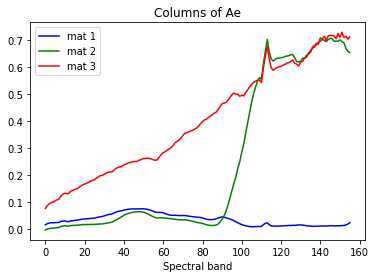

In [4]:
plt.figure(1)
plt.plot(Ae[:,0], color='blue', label='mat 1')
plt.plot(Ae[:,1], color='green', label='mat 2')
plt.plot(Ae[:,2], color='red', label='mat 3')
#plt.plot(Ae[:,3], color='black', label='mat 4')
plt.xlabel('Spectral band')
#plt.ylabel('Objective function')
plt.title('Columns of Ae')
plt.legend()
plt.show()

In [5]:
#  Reshape from matrix to tensor
T = np.reshape(A.T, (res1, res2, res3))
T = T/np.amax(T)
Ae.shape

(156, 3)

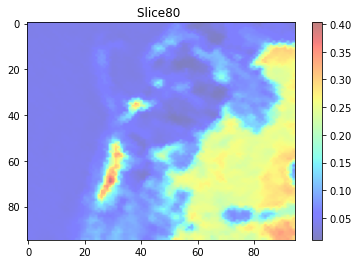

In [6]:
# Visualization of input tensor T
light_jet = cmap_map(lambda x: x/2 + 0.5, matplotlib.cm.jet)
nSlice = 80
counter_fig = 1
pl.figure(counter_fig)
pl.imshow(T[:,:,nSlice].T, cmap=light_jet, aspect='auto')
pl.title("Slice%1.0f" %nSlice+ " ")
pl.colorbar()
pl.show()
counter_fig = counter_fig + 1

In [7]:
#----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Initialization
#----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
U_lines = res1
V_lines = res2
W_lines = res3
ranks = [52,52,3]

In [8]:
# Random initialization for the NTD
factors_init = []
factors_init.append(np.random.rand(U_lines, ranks[0]))
factors_init.append(np.random.rand(V_lines, ranks[1]))
#factors_init.append(np.random.rand(W_lines, ranks[2]))
factors_init.append(Ae)
core_init = np.random.rand(ranks[0], ranks[1], ranks[2])

In [9]:
# Solver parameters
n_iter_max = 2000
beta = 1
iter_inner = 1
tol = 0 #running all iterations
l2weight = np.array([0, 0, 0, 0])  #(\mu_g, \mu_W, \mu_H, \mu_Q)
l1weight = np.array([1, 10, 10, 1])  #(\mu_g, \mu_W, \mu_H, \mu_Q)

In [10]:
#------------------------------
# Call of solvers
#----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


# ### Beta = 1 - MU no extrapolation
core, factors, cost_fct_vals, toc, alpha = SNTD.sntd_mu(T, ranks, l2weights=l2weight, l1weights=l1weight, init = "custom", core_0 = core_init, factors_0 = factors_init, n_iter_max = n_iter_max, tol=tol, beta = beta,
                                                fixed_modes = [], normalize = 4*[None], verbose = False, return_costs = True, extrapolate=False, iter_inner=iter_inner)

100%|██████████| 2000/2000 [03:41<00:00,  9.05it/s]


In [11]:
# ### Beta = 1 - MU extrapolation
core_HER, factors_HER, cost_fct_vals_HER, toc_HER, alpha_HER = SNTD.sntd_mu(T, ranks, l2weights=l2weight, l1weights=l1weight, init = "custom", core_0 = core_init, factors_0 = factors_init, n_iter_max = n_iter_max, tol=tol, beta = beta,
                                                fixed_modes = [], normalize = 4*[None], verbose = False, return_costs = True, extrapolate=True, iter_inner=iter_inner)

100%|██████████| 2000/2000 [03:40<00:00,  9.08it/s]


In [12]:
#----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Reporting
#----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
print("-----------------------------------------------------------------------")
print("Reporting results:")
print("-----------------------------------------------------------------------")
print("Final loss function value:")
print(f"MU, Beta = 1       : {cost_fct_vals[-1]}, converged in {len(cost_fct_vals) - 1} iterations.")
print(f"MU - HER, Beta = 1 : {cost_fct_vals_HER[-1]}, converged in {len(cost_fct_vals_HER) - 1} iterations.")
print("-----------------------------------------------------------------------")
print("Final relative construction error:")
print(f"MU, Beta = 1       : {tl.norm(T-tl.tenalg.multi_mode_dot(core, factors))/tl.norm(T)*100} %")
print(f"MU - HER, Beta = 1 : {tl.norm(T-tl.tenalg.multi_mode_dot(core_HER, factors_HER))/tl.norm(T)*100} %")

-----------------------------------------------------------------------
Reporting results:
-----------------------------------------------------------------------
Final loss function value:
MU, Beta = 1       : 2453.306133297385, converged in 2000 iterations.
MU - HER, Beta = 1 : 2502.9692673504055, converged in 2000 iterations.
-----------------------------------------------------------------------
Final relative construction error:
MU, Beta = 1       : 5.79514385599168 %
MU - HER, Beta = 1 : 7.299970504960017 %


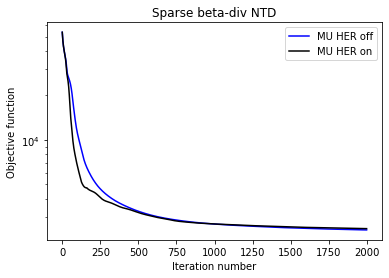

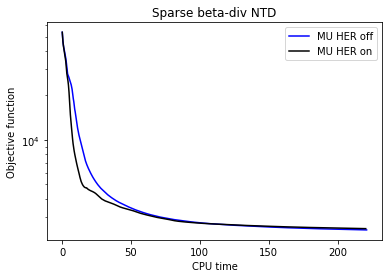

In [13]:
# first iteration shown?
it1 = 1

plt.figure(1)
plt.semilogy(cost_fct_vals[it1:], color='blue', label='MU HER off')
plt.semilogy(cost_fct_vals_HER[it1:], color='black', label='MU HER on')
plt.xlabel('Iteration number')
plt.ylabel('Objective function')
plt.title('Sparse beta-div NTD')
plt.legend()
plt.show()

plt.figure(2)
plt.semilogy(toc[it1:],cost_fct_vals[it1:], color='blue', label='MU HER off')
plt.semilogy(toc_HER[it1:],cost_fct_vals_HER[it1:], color='black', label='MU HER on')
plt.xlabel('CPU time')
plt.ylabel('Objective function')
plt.title('Sparse beta-div NTD')
plt.legend()
plt.show()

In [14]:
# norm for factors 1
if not l2weight[1]:
    print(tl.norm(factors[0],1))
else:
    print(tl.norm(factors[0],2)**2)

46.241386150377814


In [15]:
# norm for factors 2
if not l2weight[2]:
    print(tl.norm(factors[1],1))
else:
    print(tl.norm(factors[1],2)**2)

45.692038039435275


In [16]:
# norm for factors 3
if not l2weight[3]:
    print(tl.norm(factors[2],1))
else:
    print(tl.norm(factors[2],2)**2)

455.01465430555857


In [17]:
# norm for core tensor
if not l2weight[0]:
    print(tl.norm(core,1))
else:
    print(tl.norm(core,2)**2)

461.70634463238304


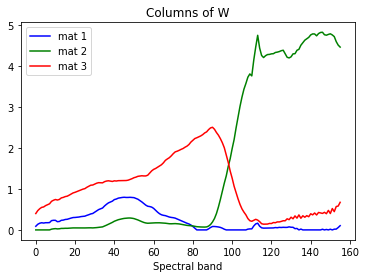

In [18]:
U = factors[0]
V = factors[1]
W = factors[2]
plt.figure(1)
plt.plot(W[:,0], color='blue', label='mat 1')
plt.plot(W[:,1], color='green', label='mat 2')
plt.plot(W[:,2], color='red', label='mat 3')
#plt.plot(W[:,3], color='black', label='mat 4')
plt.xlabel('Spectral band')
#plt.ylabel('Objective function')
plt.title('Columns of W')
plt.legend()
plt.show()

In [19]:
mode = 2
A = tl.unfold(tl.tenalg.multi_mode_dot(core, factors, skip = mode), mode)

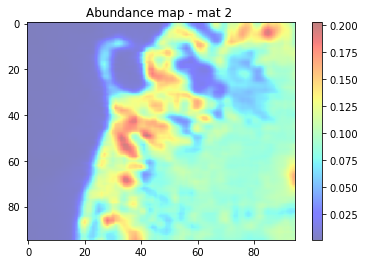

In [27]:
nMat = 1
A1 = np.reshape(A[nMat,:],(res1, res2))
nMat_graph = nMat + 1
pl.figure(counter_fig)
pl.imshow(A1.T, cmap=light_jet, aspect='auto')
pl.title("Abundance map - mat %1.0f" %nMat_graph + " ")
pl.colorbar()
pl.show()

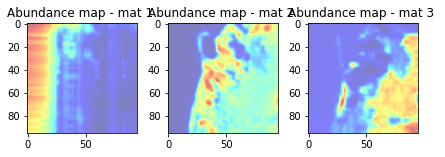

In [23]:
fig, axs = pl.subplots(1, 3)
nMat = 0
A1 = np.reshape(A[nMat,:],(res1, res2))
nMat_graph = nMat + 1
axs[0].imshow(A1.T, cmap=light_jet, aspect='auto')
axs[0].set_title("Abundance map - mat %1.0f" %nMat_graph + " ")
axs[0].set_aspect('equal', 'box')
nMat = 1
A1 = np.reshape(A[nMat,:],(res1, res2))
nMat_graph = nMat + 1
axs[1].imshow(A1.T, cmap=light_jet, aspect='auto')
axs[1].set_title("Abundance map - mat %1.0f" %nMat_graph + " ")
axs[1].set_aspect('equal', 'box')
nMat = 2
A1 = np.reshape(A[nMat,:],(res1, res2))
nMat_graph = nMat + 1
axs[2].imshow(A1.T, cmap=light_jet, aspect='auto')
axs[2].set_title("Abundance map - mat %1.0f" %nMat_graph + " ")
axs[2].set_aspect('equal', 'box')
#pl.colorbar()
fig.tight_layout()

In [24]:
# Number of variables for equivalent NMF m
(res1**2)*ranks[2]+ranks[2]*res3

27543

In [25]:
# Number of variables for equivalent NMF model:
res1*ranks[0]+res2*ranks[1]+ranks[2]*res3+ranks[0]*ranks[1]*ranks[2]

18460